In [1]:
import pandas as pd
from collections import ChainMap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#listings = pd.read_csv("data/listings.csv") Dont use this. All the data is in Listings summary
df = pd.read_csv("data/listings_summary.csv")

In [2]:
def clean_dataframe(df):
    
    df = df.copy()
    
#     keeping the columns we need
    columns = ['host_is_superhost', 'beds', 'price', 'security_deposit', 'cleaning_fee', 
        'property_type', 'minimum_nights', 'extra_people', 'latitude', 'longitude',
        'accommodates', 'bathrooms', 'bedrooms', 'cancellation_policy', 'room_type']

    df = df[columns]
    
#     stripping $ and ,
    df['cleaning_fee_cleaned'] = df['cleaning_fee'].replace({'[\$,]': ''}, regex=True).astype(float)
    df['security_deposit_cleaned'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
    df['price_cleaned'] = df['price'].replace({'[\$,]': ''}, regex=True).astype(float)
    df['extra_people_cleaned'] = df['extra_people'].replace({'[\$,]': ''}, regex=True).astype(float)
    
#     filling the NaN's
    df['cleaning_fee_filled'] = df['cleaning_fee_cleaned'].fillna(0)
    df['security_deposit_filled'] = df['security_deposit_cleaned'].fillna(0)

    
#     dropping NaN's
    df = df.dropna()
    
#     engineering new columns
    list = ['t']
    df['superhost'] = df['host_is_superhost'].isin(list)
    
#   engineering  property type
    guesthouse = ['Guest suite', 'Guesthouse']
    apartment = ['Apartment', 'Serviced apartment', 'Aparthotel']
    condo = ['Townhouse', 'Loft', 'Condominium']
    house = ['House', 'Bed and breakfast', 'Bungalow', 'Villa', 'Tiny house', 'Cabin', 'Cottage', 'Chalet']
    other = ['Hostel', 'Other', 'Boat', 'Houseboat', 'Boutique hotel', 'Camper/RV', 'Hotel', 
             'Resort', 'Train', 'Casa particular (Cuba)', 'In-law', 'Cave', 'Island']


    d = ChainMap(dict.fromkeys(guesthouse, 0), 
                 dict.fromkeys(apartment, 1), 
                 dict.fromkeys(condo, 2), 
                 dict.fromkeys(house, 3),
                 dict.fromkeys(other, 4))
    df['property_type_cleaned'] = df['property_type'].map(d.get).astype(int)
    
#     engineeering room type
    df['room_type_cleaned'] = df['room_type'].replace({'Entire home/apt':1, 'Private room':0, 'Shared room':2}).astype(int)
    
#     engineering cancelation policy
    df['cancellation_policy_cleaned'] = df['cancellation_policy'].replace({'strict_14_with_grace_period':0, 'flexible':1,
                                                                      'moderate':2, 'super_strict_30':3, 
                                                                       'super_strict_60':4}).astype(int)
    
#     turning columns into int
    df['beds'] = df['beds'].astype(int)
    df['bedrooms'] = df['bedrooms'].astype(int)
    
#     dropping outliers in columns
    df = df[(df['price_cleaned'] != 0.0) & (df['price_cleaned'] <= 1000.0)]

#     dropping extra columns
    drop_columns = ['cleaning_fee_cleaned', 'security_deposit_cleaned', 'cleaning_fee', 'security_deposit', 
                    'price', 'extra_people', 'host_is_superhost', 'property_type', 'room_type', 'cancellation_policy']
    
    df = df.drop(columns=drop_columns)
    
    return df

In [3]:
df_cleaned = clean_dataframe(df)

In [4]:
df_cleaned.head()

,beds,minimum_nights,latitude,longitude,accommodates,bathrooms,bedrooms,price_cleaned,extra_people_cleaned,cleaning_fee_filled,security_deposit_filled,superhost,property_type_cleaned,room_type_cleaned,cancellation_policy_cleaned
0,2,4,52.534537,13.402557,3,1.0,1,60.0,28.0,30.0,200.0,True,0,1,0
1,1,2,52.548513,13.404553,2,1.0,1,17.0,0.0,0.0,0.0,False,1,0,1
2,2,62,52.534996,13.417579,4,1.0,1,90.0,20.0,50.0,200.0,False,1,1,0
3,1,5,52.498855,13.349065,2,1.0,1,26.0,18.0,30.0,250.0,False,1,0,0
4,2,2,52.543157,13.415091,2,1.0,1,42.0,24.0,0.0,0.0,True,1,0,2


In [79]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(["price_cleaned"],axis=1)
y = df_cleaned["price_cleaned"]
sc.fit(X)

X_scaled = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers, metrics
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(80, input_shape=(14,), activation='tanh'))

model.add(Dense(120, activation='relu'))

model.add(Dense(20, activation='relu'))

model.add(Dense(10, activation='relu'))

model.add(Dense(1))

model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae', 'accuracy'])

model.summary()

In [80]:
t_model = Sequential()
t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(14,)))
t_model.add(Dropout(0.2))
t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
t_model.add(Dropout(0.1))
t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
t_model.add(Dropout(0.1))
t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
t_model.add(Dropout(0.0))
t_model.add(Dense(1))
t_model.compile(
    loss='mean_squared_error',
    optimizer='nadam',
    metrics=[metrics.mae])

In [81]:
t_model.fit(X_train, y_train,
    batch_size=125,
    epochs=500,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test))

Train on 11017 samples, validate on 1225 samples
Epoch 1/500
11017/11017 [==============================] - 0s 42us/step - loss: 3266.4388 - mean_absolute_error: 35.5154 - val_loss: 2876.2585 - val_mean_absolute_error: 42.0418
Epoch 2/500
11017/11017 [==============================] - 0s 17us/step - loss: 1994.9618 - mean_absolute_error: 26.2815 - val_loss: 1942.9420 - val_mean_absolute_error: 24.1692
Epoch 3/500
11017/11017 [==============================] - 0s 17us/step - loss: 1878.0945 - mean_absolute_error: 25.3300 - val_loss: 1729.3647 - val_mean_absolute_error: 27.7147
Epoch 4/500
11017/11017 [==============================] - 0s 17us/step - loss: 1837.4282 - mean_absolute_error: 24.9541 - val_loss: 1692.9014 - val_mean_absolute_error: 23.0828
Epoch 5/500
11017/11017 [==============================] - 0s 17us/step - loss: 1826.6918 - mean_absolute_error: 24.7113 - val_loss: 1766.6481 - val_mean_absolute_error: 23.3923
Epoch 6/500
11017/11017 [==============================] - 0s

In [91]:
scores = t_model.evaluate(X_test,y_test)
print(f"{t_model.metrics_names[1]}: {scores[1]*100}")

index = 90

X_pred = [df_cleaned.drop('price_cleaned', axis=1).iloc[index]]
y_real = df_cleaned.iloc[index]['price_cleaned']
y_pred = t_model.predict([X_pred])

print(f'Prediction: ${y_pred[0][0]} | Real: ${y_real}')

1225/1225 [==============================] - 0s 20us/step
mean_absolute_error: 2179.758834838867
Prediction: $98.46346282958984 | Real: $75.0


In [92]:
def save_model():
    # serialize model to JSON
    model_json = t_model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    t_model.save_weights("model.h5")
    print("Saved model to disk")

Saved model to disk


In [143]:
df_cleaned = clean_dataframe(df)

In [182]:
lat_bins, ret = pd.cut(df_cleaned['latitude'], bins=500, precision=5, retbins=True)
lng_bins, ret = pd.cut(df_cleaned['longitude'], bins=500, precision=5, retbins=True)

#test = lat_bins.groupby(1, axis=1)

latlng = df_cleaned.sample(n=500)

#latlng.shape

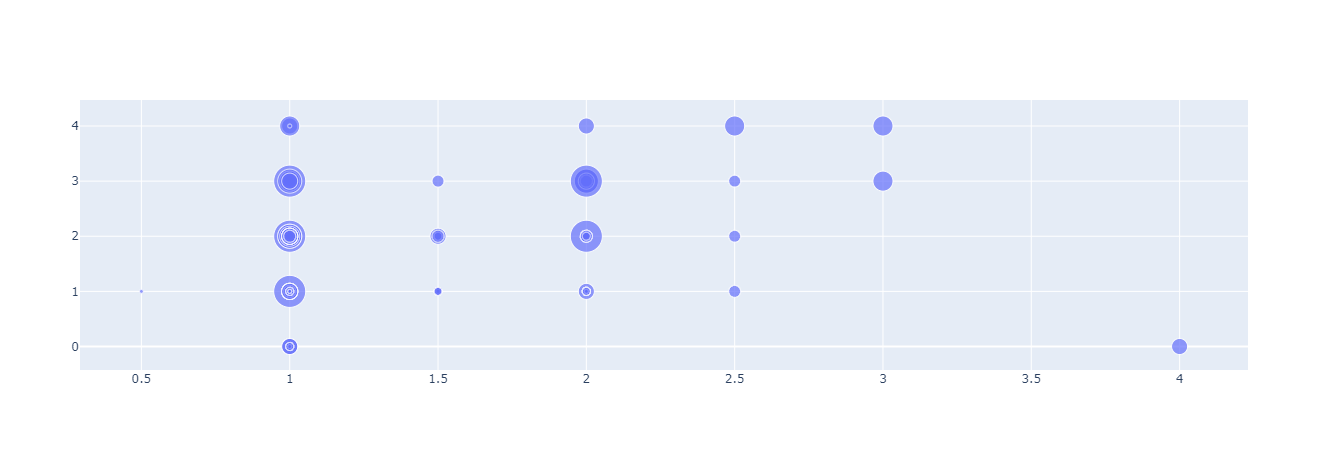

In [189]:
fig = go.Figure(data=[go.Scatter(
    x=latlng["bathrooms"],
    y=latlng["bedrooms"],
    mode="markers",
    marker={
    'size':latlng['beds']*4,
    'sizemin':1}
)])

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
    lon=latlng['longitude'],
    lat=latlng['latitude'],
    mode='markers',
    marker = dict(
            size = 3,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            )
        )))
fig.update_layout(
    geo = dict(
        scope = 'europe',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 200)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 110,
        projection = dict(
            type = 'equirectangular'
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 1,
            range= [ 13.0, 14.0 ],
            dtick = 10
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 1,
            range= [ 52.0, 53.0 ],
            dtick = 10
        )
    ),
    title='US Precipitation 06-30-2015<br>Source: <a href="http://water.weather.gov/precip/">NOAA</a>',
    width=1000,height=1000,autosize=False
)

fig.show()